Video Decomposition via Robust PCA
==================================

This example demonstrates video foreground/background separation via a
variant of the Robust PCA problem

  $$\mathrm{argmin}_{\mathbf{x}_0, \mathbf{x}_1} \; (1/2) \| \mathbf{x}_0
      + \mathbf{x}_1 - \mathbf{y} \|_2^2 + \lambda_0 \| \mathbf{x}_0 \|_*
      + \lambda_1 \| \mathbf{x}_1 \|_1 \;,$$

where $\mathbf{x}_0$ and $\mathbf{x}_1$ are respectively low-rank and
sparse components, $\| \cdot \|_*$ denotes the nuclear norm, and
$\| \cdot \|_1$ denotes the $\ell_1$ norm.

Note: while video foreground/background separation is not an example of
the scientific and computational imaging problems that are the focus of
SCICO, it provides a convenient demonstration of Robust PCA, which does
have potential application in scientific imaging problems.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico

import imageio

import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.examples import rgb2gray
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Load example video.

In [2]:
reader = imageio.get_reader("imageio:newtonscradle.gif")
nfrm = reader.get_length()
frmlst = []
for i, frm in enumerate(reader):
    frmlst.append(rgb2gray(frm[..., 0:3].astype(snp.float32) / 255.0))
vid = snp.stack(frmlst, axis=2)

Construct matrix with each column consisting of a vectorised video frame.

In [3]:
y = vid.reshape((-1, vid.shape[-1]))

Define functional for Robust PCA problem.

In [4]:
A = linop.Sum(axis=0, input_shape=(2,) + y.shape)
f = loss.SquaredL2Loss(y=y, A=A)
C0 = linop.Slice(idx=0, input_shape=(2,) + y.shape)
g0 = functional.NuclearNorm()
C1 = linop.Slice(idx=1, input_shape=(2,) + y.shape)
g1 = functional.L1Norm()

Set up an ADMM solver object.

In [5]:
λ0 = 1e1  # nuclear norm regularization parameter
λ1 = 3e1  # l1 norm regularization parameter
ρ0 = 2e1  # ADMM penalty parameter
ρ1 = 2e1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[λ0 * g0, λ1 * g1],
    C_list=[C0, C1],
    rho_list=[ρ0, ρ1],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.89e+00  2.754e+05  7.669e+02  8.042e+02      1  9.455e-09
  10  4.73e+00  8.573e+03  2.368e-01  1.042e+00      1  6.831e-05


  20  4.88e+00  8.476e+03  2.433e-02  4.559e-01      1  2.762e-05


  30  5.03e+00  8.453e+03  1.353e-02  2.569e-01      1  1.535e-05
  40  5.15e+00  8.446e+03  7.499e-03  1.423e-01      1  8.506e-06


  49  5.26e+00  8.444e+03  4.829e-03  9.166e-02      1  5.498e-06


Plot convergence statistics.

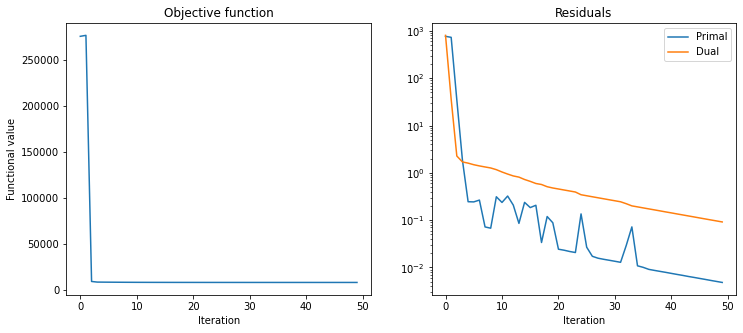

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()

Reshape low-rank component as background video sequence and sparse component
as foreground video sequence.

In [8]:
xlr = C0(x)
xsp = C1(x)
vbg = xlr.reshape(vid.shape)
vfg = xsp.reshape(vid.shape)

Display original video frames and corresponding background and foreground frames.

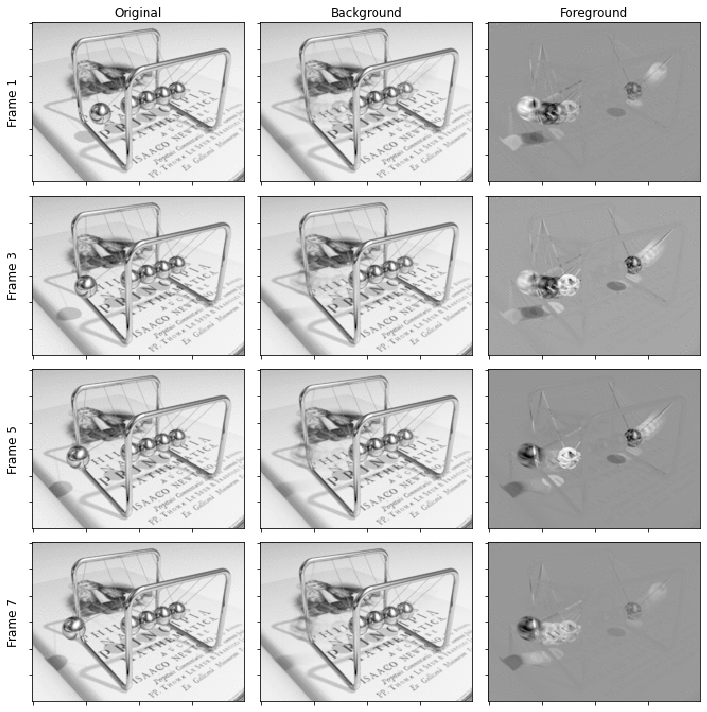

In [9]:
fig, ax = plot.subplots(nrows=4, ncols=3, figsize=(10, 10))
ax[0][0].set_title("Original")
ax[0][1].set_title("Background")
ax[0][2].set_title("Foreground")
for n, fn in enumerate(range(1, 9, 2)):
    plot.imview(vid[..., fn], fig=fig, ax=ax[n][0])
    plot.imview(vbg[..., fn], fig=fig, ax=ax[n][1])
    plot.imview(vfg[..., fn], fig=fig, ax=ax[n][2])
    ax[n][0].set_ylabel("Frame %d" % fn, labelpad=5, rotation=90, size="large")
fig.tight_layout()
fig.show()